<a href="https://colab.research.google.com/github/phoebezhouhuixin/NLPwithTF/blob/master/embeddings_subwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -q tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete12Y2GJ/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete12Y2GJ/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete12Y2GJ/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [ ]:
info.features # FeaturesDict is similar to a json object

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

# SubwordEncoder (i.e. vectorizing each string into a sequence using subwords instead of words)

What is `<SubwordTextEncoder vocab_size=8185>`?

Comparison: when we imported using `imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)`, we had

        FeaturesDict({
            'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
            'text': Text(shape=(), dtype=tf.string),
        })

The shape of a review went from `(1)` , i.e. a scalar string tensor (recall that length of string is not one of the dimensions), to `(None,1)`.


This is because when we imported `imdbreviews/subwords8k`, the review strings were already tokenized by `<SubwordTextEncoder vocab_size=8185>`. There are None subwords in each review.

We can take a look at what this SubwordTextEncoder does:

In [ ]:
tokenizer = info.features['text'].encoder
tokenizer

<SubwordTextEncoder vocab_size=8185>

In [ ]:
# help(tokenizer)

In [ ]:
sample_string = 'TensorFlow, from basics to mastery'
tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}, {}'.format(tokenized_string, type(tokenized_string)))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for ts in tokenized_string:
    print("{} --> {}".format(ts, tokenizer.decode([ts])))

# Note that subwords are case-senesitive

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050], <class 'list'>
The original string: TensorFlow, from basics to mastery
6307 --> Ten
2327 --> sor
4043 --> Fl
2120 --> ow
2 --> , 
48 --> from 
4249 --> basi
4429 --> cs 
7 --> to 
2652 --> master
8050 --> y


# tf.Dataset preprocessing 

In [ ]:
BUFFER_SIZE = 10000
train_dataset = train_data.shuffle(BUFFER_SIZE) 
# Fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. 
# For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

print(tf.compat.v1.data.get_output_shapes(train_dataset)) # Consists of (shape of each review, shape of each label) # (None, 1)
BATCH_SIZE = 64
train_dataset = train_dataset.padded_batch(BATCH_SIZE, padded_shapes = tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, padded_shapes = tf.compat.v1.data.get_output_shapes(test_data))

# Pad each component of the output element to the shape specified in padded_shapes = _. 
# If the padded_shape has a constant dimension (note that blank means 1) for a certain component, the component with be padded to that length in that dimension.  
# If the padded_shape has unknown (i.e. dynamic, i.e. None) dimension for a certain component, the component will be padded out to the maximum length of all elements in that component

print(train_dataset) # Consists of ((batch_size, shape of X (reviews)), (batch_size, shape of y (labels))
# In this case, both batch_size and the shape of X (reviews) is unknown (None), i.e. GENERATED AT RUNTIME i.e. dynamic

(TensorShape([None]), TensorShape([]))
<DatasetV1Adapter shapes: ((None, None), (None,)), types: (tf.int64, tf.int64)>


In [ ]:
print(tf.constant(5))

tf.Tensor(5, shape=(), dtype=int32)


# Train

In [ ]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim), 
    # tokenizer is a SubwordTextEncoder.
    # input_length is left as dynamic (i.e. None), determined by 
    # the length of each movie review's subword token sequence.
    '''
    Model: "sequential"
    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    embedding (Embedding)        (None, None, 64)          523840    
    _________________________________________________________________
    '''
    
    # how come no need to specify input_length? 
    # oh because in this case, we leave the input_length as unknown i.e. dynamic (None), rather than input_length = max_length,
    # which would have resulted in embedding layer output shape of (None, max_length, embedding_dim) ,
    # instead of (None, None, embedding_dim) shown below.
    # We can do this because train_dataset is a tf Dataset rather than a np array?
    
    tf.keras.layers.GlobalAveragePooling1D(),
    # use global ave pooling instead of flatten, because flattening causes tf crash (why?)
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 16s 41ms/step - loss: 0.6799 - accuracy: 0.6227 - val_loss: 0.6372 - val_accuracy: 0.7582
Epoch 2/10
391/391 [==============================] - 16s 41ms/step - loss: 0.5294 - accuracy: 0.7930 - val_loss: 0.4612 - val_accuracy: 0.7966
Epoch 3/10
391/391 [==============================] - 16s 41ms/step - loss: 0.3734 - accuracy: 0.8663 - val_loss: 0.3655 - val_accuracy: 0.8612
Epoch 4/10
391/391 [==============================] - 16s 42ms/step - loss: 0.2999 - accuracy: 0.8922 - val_loss: 0.3323 - val_accuracy: 0.8686
Epoch 5/10
391/391 [==============================] - 16s 41ms/step - loss: 0.2598 - accuracy: 0.9069 - val_loss: 0.3198 - val_accuracy: 0.8717
Epoch 6/10
391/391 [==============================] - 16s 42ms/step - loss: 0.2337 - accuracy: 0.9158 - val_loss: 0.3113 - val_accuracy: 0.8759
Epoch 7/10
391/391 [==============================] - 16s 41ms/step - loss: 0.2134 - accuracy: 0.9226 - val_loss: 0.3085 - val_accuracy:

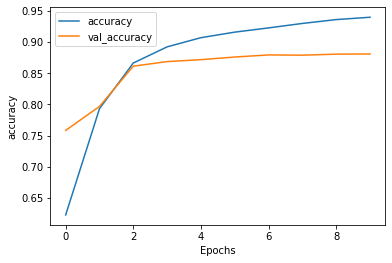

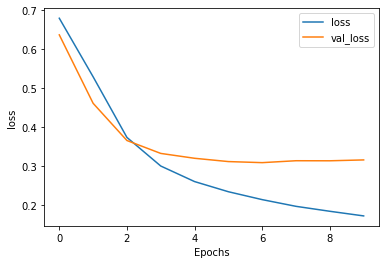

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

The accuracy is not as high as when we used full words (instead of subwords). Why? Because subwords are meant to be interpreted in SEQUENCE (sequence models!), not standalone nonsensical words

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

(8185, 64)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>